In [1]:
import pandas as pd
import numpy as np
import datetime
from EvGym import config

In [2]:
pd.Timedelta(2.333, unit='h')

Timedelta('0 days 02:19:58.800000')

In [3]:
file = "data/data-SDG/0 Generated sample (AC,poisson_fit) Horizon =2015-01-01-to-2015-12-31.csv"
df_sdg = pd.read_csv(file, parse_dates = ["Date"])
df_sdg = df_sdg.drop(["AM_specs", "MMc_specs", "MMe_specs"], axis = 1)
len(df_sdg)
df_sdg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362125 entries, 0 to 362124
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             362125 non-null  datetime64[ns]
 1   Arrival          362125 non-null  float64       
 2   Connected_time   362125 non-null  float64       
 3   Energy_required  362125 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.1 MB


In [4]:
df_sdg["starttime_parking"] = df_sdg["Date"] + pd.to_timedelta(df_sdg["Arrival"], unit='h')
df_sdg["month"] = df_sdg["starttime_parking"].dt.month
df_sdg["day"] = df_sdg["starttime_parking"].dt.day
df_sdg["ts_arr"] = np.floor((df_sdg["starttime_parking"] - config.starttime_min).dt.total_seconds()/ config.timestep)
df_sdg["ts_dep"] = np.ceil(df_sdg["ts_arr"] +  df_sdg["Connected_time"])
df_sdg["soc_arr"] = np.clip(config.FINAL_SOC - 0.01 -df_sdg["Energy_required"]**config.sdg_pot / config.sdg_norm**config.sdg_pot,
                             0, config.FINAL_SOC)
df_sdg["laxity"] = (df_sdg["ts_dep"] - df_sdg["ts_arr"]) - ((config.FINAL_SOC - df_sdg["soc_arr"])* config.B) / (config.alpha_c*config.eta_c)
#df_elaad["laxity"] = df_elaad["connected_time"] - (config.FINAL_SOC - df_elaad["soc_arr"]) * config.B / (config.alpha_c*config.eta_c)
df_sdg = df_sdg[df_sdg["laxity"] > 0].reset_index(drop = True)
df_sdg["idSess"] = df_sdg.index

In [5]:
df_sdg.describe()

,Arrival,Connected_time,Energy_required,month,day,ts_arr,ts_dep,soc_arr,laxity,idSess
count,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000,291294.000000
mean,13.449159,7.477163,6.739485,6.898364,15.683117,136148.507597,136156.495015,0.677785,5.818847,145646.500000
std,4.925644,5.115885,3.641998,3.524273,8.792966,2584.443839,2584.238927,0.216338,4.818157,84089.478994
min,0.076923,0.000185,0.000092,1.000000,1.000000,131496.000000,131502.000000,0.000000,0.000048,0.000000
25%,9.031746,3.183832,3.818685,4.000000,8.000000,133878.000000,133884.000000,0.550359,1.836313,72823.250000
50%,13.864198,6.143750,6.713087,7.000000,16.000000,136267.000000,136281.000000,0.710837,4.432917,145646.500000
75%,17.337146,11.133596,9.159506,10.000000,23.000000,138470.000000,138476.000000,0.858965,8.852506,218469.750000
max,23.952381,23.998291,23.965762,12.000000,31.000000,140255.000000,140273.000000,0.960000,23.925787,291293.000000


In [6]:
df_sdg.to_csv("data/df_sdg1_preproc_all.csv", index = False)

In [7]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
idx_array = df_sdg["idSess"].values
idx_array = np.random.permutation(idx_array)
idxs_splits = np.array_split(idx_array, 30)
df_sdg["split"] = 0
for i, arr in enumerate(idxs_splits):
    df_sdg.loc[arr, "split"] = i
    df_sdg_sub = df_sdg[df_sdg["split"] == i]
    df_sdg_sub.to_csv(f"data/preproc-SDG-splits/df_sdg1_preproc_{i}.csv", index = False)
    print(len(arr))


9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9710
9709
9709
9709
9709
9709
9709


<Axes: xlabel='split', ylabel='ts_arr'>

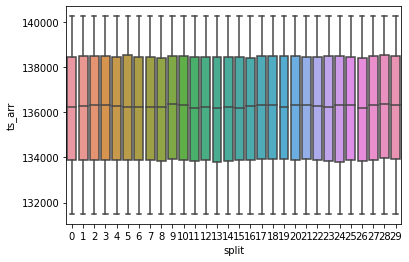

In [9]:
sns.boxplot(x="split", y="ts_arr", data=df_sdg)

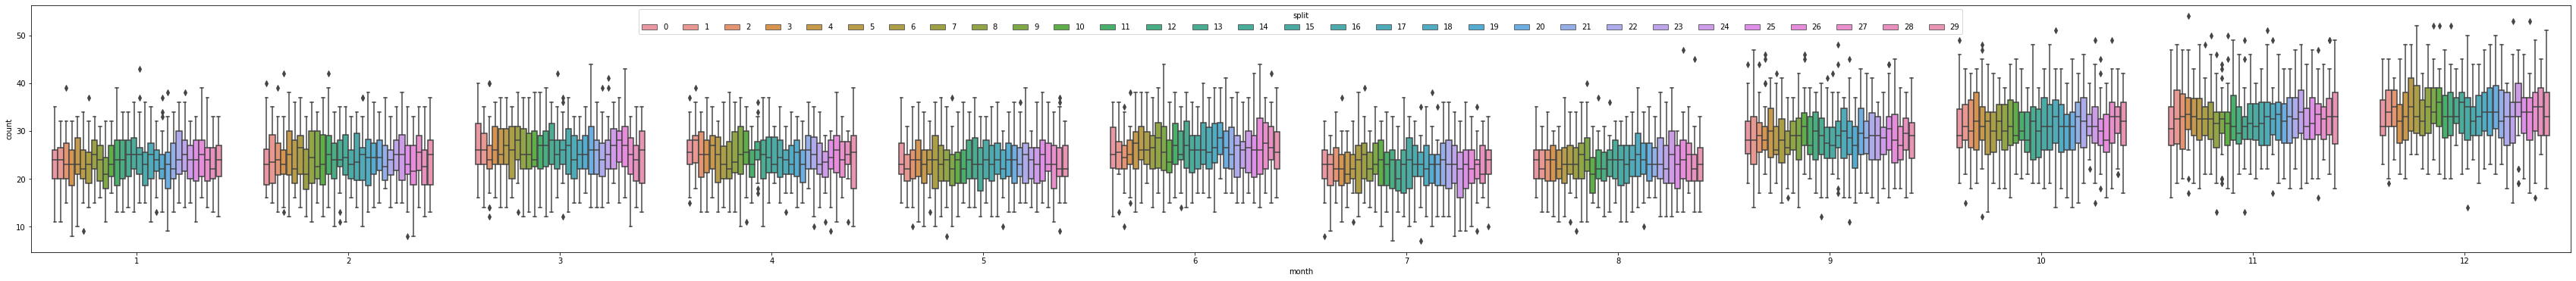

In [10]:
count_sdg = df_sdg.groupby(["day", "month", "split"]).agg(count = ("idSess", "count")).reset_index()
fig1 = plt.figure(figsize=(60, 6))
ax1 = fig1.add_subplot(111)
sns.boxplot(x="month", y="count", hue = "split",  data=count_sdg, ax = ax1)
sns.move_legend(ax1, "upper center", ncol = 30)
